In [1]:
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import rv_continuous

In [2]:
np.random.seed(42)

# mixed device is good for bloch sphere plots
dev = qml.device('default.mixed', wires=1)

class sin_prob_dist(rv_continuous):
    def _pdf(self, theta):
        return 0.5 * np.sin(theta)
    
# Some unknown distribution
class cos_prob_dist(rv_continuous):
    def _pdf(self, theta):
        return 0.5 * np.cos(theta)
    
# Samples drawn from between 0 and pi
sin_sampler = sin_prob_dist(a=0, b=np.pi)
dist_sampler = cos_prob_dist(a=0, b=np.pi)

@qml.qnode(dev)
def haar_random_unitary():
    phi, omega = 2 * np.pi * np.random.uniform(size=2)
    theta = sin_sampler.rvs()
    qml.Rot(phi, theta, omega, wires=0)
    return qml.state()

@qml.qnode(dev)
def dist_random_unitary():
    phi, omega = 2 * np.pi * np.random.uniform(size=2)
    theta = dist_sampler.rvs()
    qml.Rot(phi, theta, omega, wires=0)
    return qml.state()

num_samples = 1000
dist_samples = [dist_random_unitary() for _ in range(num_samples)]

X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
Z = np.array([[1, 0], [0, -1]])

def convert_to_bloch_vector(rho):
    ax = np.trace(np.dot(rho, X)).real
    ay = np.trace(np.dot(rho, Y)).real
    az = np.trace(np.dot(rho, Z)).real
    return [ax, ay, az]

distribution_bloch_vectors = np.array([convert_to_bloch_vector(s) for s in dist_samples])

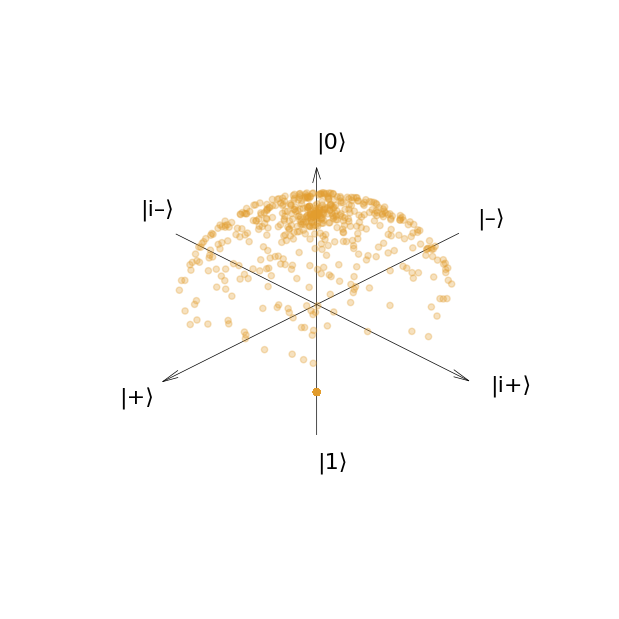

In [3]:
def plot_bloch_sphere(bloch_vectors):
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111, projection='3d')
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

    ax.grid(False)
    ax.set_axis_off()
    ax.view_init(30, 45)
    ax.dist = 7

    x, y, z = np.array([[-1.5,0,0], [0, -1.5, 0], [0, 0, -1.5]])
    u, v, w = np.array([[3,0,0], [0, 3, 0], [0,0,3]])
    ax.quiver(x, y, z, u, v, w, arrow_length_ratio=0.05, color="black", linewidth=0.5)

    ax.text(0, 0, 1.7, r"|0⟩", color="black", fontsize=16)
    ax.text(0, 0, -1.9, r"|1⟩", color="black", fontsize=16)
    ax.text(1.9, 0, 0, r"|+⟩", color="black", fontsize=16)
    ax.text(-1.7, 0, 0, r"|–⟩", color="black", fontsize=16)
    ax.text(0, 1.7, 0, r"|i+⟩", color="black", fontsize=16)
    ax.text(0,-1.9, 0, r"|i–⟩", color="black", fontsize=16)

    ax.scatter(bloch_vectors[:, 0], bloch_vectors[:, 1], bloch_vectors[:, 2], c="#e29d2e", alpha=0.3)
    
plot_bloch_sphere(distribution_bloch_vectors)

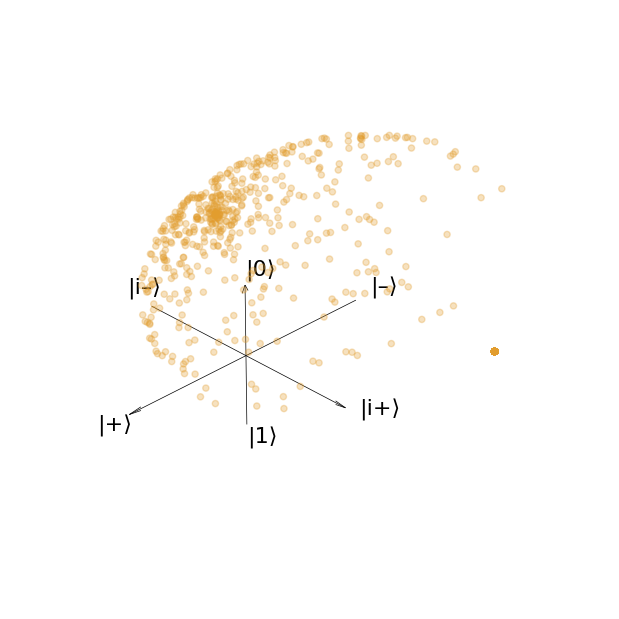

In [4]:
# Random unitaries to scramble the sampled states
# TODO: Add seed for recreatibility
def generate_random_unitary(num_qubits, t=5):
    return [qml.math.linalg.expm(1j * np.random.randn(2 ** num_qubits, 2 ** num_qubits)) for _ in range(t)]

num_qubits = 1
t = 5
random_unitaries = generate_random_unitary(num_qubits, t)

def forward_scrambling(states, unitaries):
    scrambled_states = []
    for state in states:
        for U in unitaries:
            state = U @ state
        scrambled_states.append(state)
    return np.array(scrambled_states)

# qml.QubitUnitary(random_unitaries, 1)

# input_state = np.array([1, 0]) # Dummy test |0>
# phis = np.random.uniform(0, 2 * np.pi, 3 * 2) # random rotation angles
# final_state = forward_scrambling(input_state, phis, t)
# print(final_state)

# scrambled_states = [forward_scrambling(s, phis, t) for s in haar_samples]

scrambled_states = forward_scrambling(dist_samples, random_unitaries)
scrambled_bloch_states = np.array([convert_to_bloch_vector(s) for s in scrambled_states])
plot_bloch_sphere(scrambled_bloch_states)

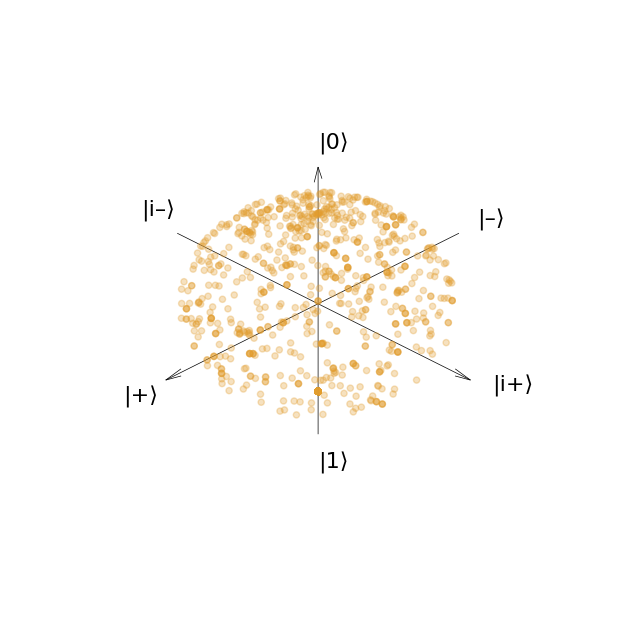

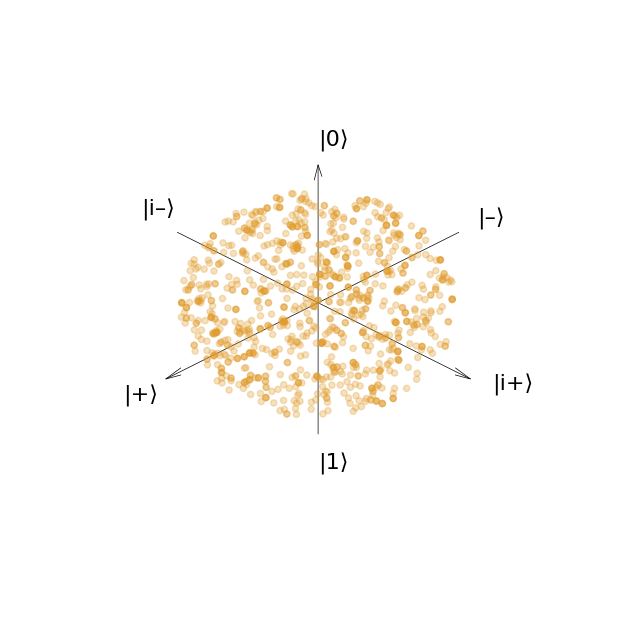

In [5]:
from scipy.stats import unitary_group

seed = 42

def haar_random_unitary(seed=None):
    if seed is not None:
        np.random.seed(seed)
    return unitary_group.rvs(2)

def scramble_state_vectors(state_vectors, seed):
    scrambled_vectors = []

    for i in range(num_samples):
        U = haar_random_unitary(seed)
        
        scrambled_state = np.dot(U, state_vectors[i])
        scrambled_state /= np.linalg.norm(scrambled_state)
        scrambled_vectors.append(scrambled_state)

        # Half way point for Bloch visualization
        if i == num_samples//2:
            scrambled_bloch_states = np.array([convert_to_bloch_vector(s) for s in np.array(scrambled_vectors)])
            remaining_bloch_vectors = np.array([convert_to_bloch_vector(s) for s in state_vectors[i-1:]])
            half_scrambled_states = np.concatenate((scrambled_bloch_states, remaining_bloch_vectors), axis=0)
            plot_bloch_sphere(half_scrambled_states)

        if seed is not None:
            if i % 4 == 0:
                seed += 1

    return np.array(scrambled_vectors)

scrambled_states = scramble_state_vectors(np.array(dist_samples), seed)
scrambled_bloch_states = np.array([convert_to_bloch_vector(s) for s in scrambled_states])
plot_bloch_sphere(scrambled_bloch_states)

## Denoising ## 

In [20]:
@qml.qnode(dev)
def denoising_circuit(state, params):
    state = state / np.linalg.norm(state)
    qml.QubitStateVector(state, wires=0)
    qml.Rot(*params, wires=0)
    return qml.state()

# Hardware efficient ansatz
# @qml.qnode(dev)
# def denoising_circuit(state, params):
#     qml.QubitStateVector(state, wires=0)
#     qml.RY(params[0], wires=0)
#     qml.RZ(params[1], wires=0)
#     return qml.state()

def denoising_step(scrambled_states, params):
    denoised_states = []
    count = 0
    for state in scrambled_states:
        print(count)
        state = state / np.linalg.norm(state)
        denoised_state = denoising_circuit(state, params)
        denoised_states.append(denoised_state / np.linalg.norm(denoised_state))
    return np.array(denoised_states)

def loss_function(denoised_states, original_states):
    return np.mean(np.sum(np.abs(denoised_states - original_states)**2, axis=1))

def train_denoising(scrambled_states, original_states, num_epochs, learning_rate=0.1):
    params = np.random.rand(3)
    opt = qml.GradientDescentOptimizer(stepsize=learning_rate)

    for epoch in range(num_epochs):
        denoised_states = denoising_step(scrambled_states, params)
        loss = loss_function(denoised_states, original_states)
        params = opt.step(lambda v: loss_function(denoising_step(scrambled_states, v)))
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss}")

    return params



In [22]:
T = 5
num_epochs = 100
learning_rate = 0.1

original_states = dist_samples
optimized_params = train_denoising(scrambled_states, original_states, num_epochs, learning_rate)


0


ValueError: Sum of amplitudes-squared does not equal one.